#Introduction:

Try to find out the correlation between pitchers' weight, height, pitch type, pitch velocity, horizontal, vertical movement and their onset of Tommy John Surgery.

#Methods:

Pitchers' pitch type, pitch velocity, horizontal, vertical movement data was from FanGraphs<br>
Pitchers' debut date was from Lahman baseball database<br>
Pitchers' Tommy John Surgery date was from Wikipedia<br>
Players can have multiple Tommy John surgeries throughout their career, in this research we only focus on the time span between their debut and first surgery<br>
Data include 146 MLB pitchers making debut from 2000-2020 who at least had one Tommy John surgery during his career

##Step1: Import the data 

In [1]:
#import packages
import pandas as pd
import pyodbc

#connect with sql server and retrieve the data we want
sql_conn = pyodbc.connect('''DRIVER={ODBC Driver 13 for SQL Server};
                            SERVER=ALLENHO\MSSQLSERVER002;
                            DATABASE=TommyJohn;
                            Trusted_Connection=yes''')
query = '''
select t.PlayerName, t.firstTJ, datediff(day, p.debut, t.firstTJ) as debuttofirstTJ, t.Throwarm, p.weight, p.height,
k.FBp, k.FBv, abs(h.FAX) as FBhm, abs(v.FAZ) as FBvm,
k.SLp, k.SLv, abs(h.SIX) as SLhm, abs(v.SIZ) as SLvm,
k.CBp, k.CBv, abs(h.CUX) as CBhm, abs(v.CUZ) as CBvm,
k.CHp, k.CHv, abs(h.CHX) as CHhm, abs(v.CHZ) as CHvm
from TJS t
left join People p
on t.PlayerName=concat(p.nameFirst,' ',p.nameLast)
left join Pitchtype k
on t.PlayerName=k.Name
left join Horizontal h
on t.PlayerName=h.Name
left join Vertical v
on t.PlayerName=v.Name
where (datediff(day, p.debut, t.firstTJ) between 0 and 5200) and (p.debut>='2000-01-01') and FBp is not null
order by t.PlayerName
'''

#convert the data into dataframe
df = pd.read_sql(query, sql_conn)

#take a look at the data
print(df)

          PlayerName     firstTJ  debuttofirstTJ Throwarm  weight  height  \
0      Aaron Barrett  2015-09-03             521    Right   230.0    75.0   
1    Adam Wainwright  2011-02-28            1996    Right   235.0    79.0   
2          Alex Cobb  2015-05-14            1474    Right   205.0    75.0   
3         Alex Reyes  2017-02-16             191    Right   175.0    75.0   
4    Ambiorix Burgos  2007-08-28             857    Right   235.0    75.0   
..               ...         ...             ...      ...     ...     ...   
141       Will Smith  2017-03-30            1772     Left   248.0    77.0   
142      Yimi Garcia  2016-10-25             785    Right   225.0    72.0   
143       Yu Darvish  2015-03-17            1072    Right   220.0    77.0   
144        Zach Duke  2016-10-14            4122     Left   210.0    74.0   
145      Zach Putnam  2017-06-01            2088    Right   220.0    74.0   

       FBp   FBv  FBhm  FBvm  ...  SLhm  SLvm    CBp   CBv  CBhm  CBvm    C

###Column meaning:
firstTJ: the date that player got their Tommy John surgery<br>
debuttofirstTJ: time span between player's debut and his first TJ surgery<br>
FB: Fastball<br>
SL: Slider<br>
CB: Curveball<br>
CH: Changeup<br>
p: percentage (for example, FBp means Fastball percentage)<br>
v: velocity (for example, FBv means Fastball velocity)<br>
hm: horizontal movement (for example, FBhm means Fastball horizontal movement)<br>
vm: vertical movement(for example, FBvm means Fastball vertical movement)

##Step2: Build the correlation table between debuttofirstTJ and all the variables

In [2]:
#get the correlation table from df
from scipy.stats.stats import pearsonr
df_corr = df.corr()
print(df_corr.loc['debuttofirstTJ',:])

debuttofirstTJ    1.000000
weight           -0.049555
height            0.010899
FBp               0.058668
FBv              -0.220199
FBhm             -0.001171
FBvm              0.033241
SLp              -0.257609
SLv              -0.236190
SLhm              0.010553
SLvm             -0.056894
CBp               0.023230
CBv              -0.096009
CBhm             -0.015895
CBvm             -0.067654
CHp              -0.085662
CHv              -0.209635
CHhm             -0.070154
CHvm              0.026258
Name: debuttofirstTJ, dtype: float64


Keep in mind that a minus correlation is not weaker than a plus correlation; they’re the same strength, only in opposite directions. For example, in a +0.8 correlation, when one stat gets higher, the other also tends to; in -0.8, when one goes up, the other goes down. So it’s the absolute value we care about the most.<br>

As it turned out,  <br>
Fastball velocity -0.220199;<br>
Slider percentage -0.251877;<br>
Slider velocity   -0.230935;<br>
Changeup velocity -0.203029<br>
are the four most significant factors related to first Tommy John Surgery onset time.<br>

Also we can see that these four are all negatively related, which means the bigger they are, the quicker these pitchers got their first Tommy John Surgery.<br>

However keep in mind that Pearson correlation doesn't imply one variable cause another to happen. We can only say based on what we saw, out of these variables, it is these four that are most significantly negatively correlate with first Tommy John Surgery onset time.

Then take a closer look at these four variables to reassure these Pearson correlation are statistically signicant(P<0.05)
SLp, SLv, CHp need some fill in for the NA value(not every pitcher throw these type of pitches). I use the mean of the whole dataset for these missing values.

In [3]:
pearsonr(df.loc[:,'FBv'],df.loc[:,'debuttofirstTJ'])

(-0.2201985352799605, 0.007570195161803116)

In [4]:
mean_SLp=df['SLp'].mean()
df['SLp']=df['SLp'].fillna(mean_SLp)
pearsonr(df.loc[:,'SLp'],df.loc[:,'debuttofirstTJ'])

(-0.2518767265489322, 0.002163051260958012)

In [5]:
mean_SLv=df['SLv'].mean()
df['SLv']=df['SLv'].fillna(mean_SLv)
pearsonr(df.loc[:,'SLv'],df.loc[:,'debuttofirstTJ'])

(-0.2309346712902471, 0.005040712073583125)

In [6]:
mean_CHp=df['CHv'].mean()
df['CHv']=df['CHv'].fillna(mean_CHp)
pearsonr(df.loc[:,'CHv'],df.loc[:,'debuttofirstTJ'])

(-0.20302852126176202, 0.013980261646684347)

##Step 3: Visualization of the correlation table

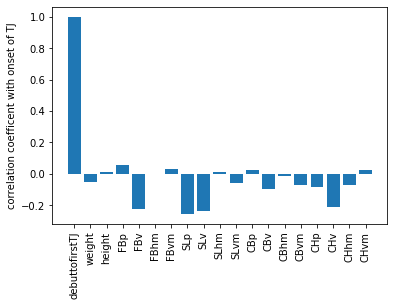

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
fig, ax = plt.subplots()

#-----plot the correlation table as bar plot----------------------
ax.bar(df_corr.index, df_corr['debuttofirstTJ'])

ax.set_xticklabels(df_corr.index, rotation=90)

ax.set_ylabel('correlation coefficent with onset of TJ')

plt.show()

Closer look at the comparison of percentage usage of all four types of pitches

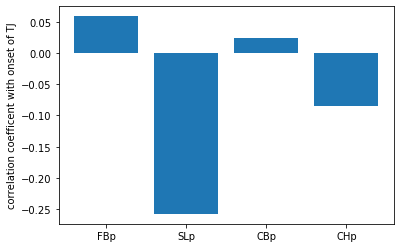

In [8]:
fig, ax = plt.subplots()

df_corr_percentage=df_corr.loc[['FBp','SLp','CBp','CHp'],:]

ax.bar(df_corr_percentage.index, df_corr_percentage['debuttofirstTJ'])

ax.set_xticklabels(df_corr_percentage.index)

ax.set_ylabel('correlation coefficent with onset of TJ')

plt.show()

Closer look at the comparison of velocity of all four types of pitches

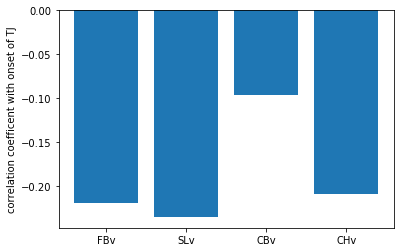

In [9]:
fig, ax = plt.subplots()

df_corr_velocity=df_corr.loc[['FBv','SLv','CBv','CHv'],:]

ax.bar(df_corr_velocity.index, df_corr_velocity['debuttofirstTJ'])

ax.set_xticklabels(df_corr_velocity.index)

ax.set_ylabel('correlation coefficent with onset of TJ')

plt.show()

Closer look at the comparison of horizontal movement of all four types of pitches

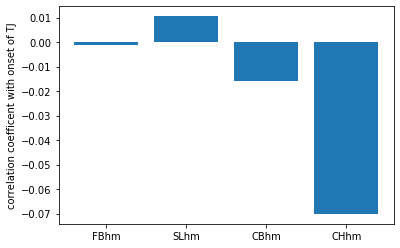

In [10]:
fig, ax = plt.subplots()

df_corr_percentage=df_corr.loc[['FBhm','SLhm','CBhm','CHhm'],:]

ax.bar(df_corr_percentage.index, df_corr_percentage['debuttofirstTJ'])

ax.set_xticklabels(df_corr_percentage.index)

ax.set_ylabel('correlation coefficent with onset of TJ')

plt.show()

Closer look at the comparison of vertical movement of all four types of pitches

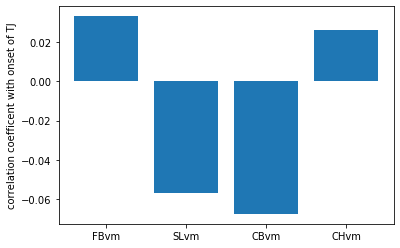

In [11]:
fig, ax = plt.subplots()

df_corr_percentage=df_corr.loc[['FBvm','SLvm','CBvm','CHvm'],:]

ax.bar(df_corr_percentage.index, df_corr_percentage['debuttofirstTJ'])

ax.set_xticklabels(df_corr_percentage.index)

ax.set_ylabel('correlation coefficent with onset of TJ')

plt.show()

Take a look at the scatter plot of the most significant variables: Slider percentage usage

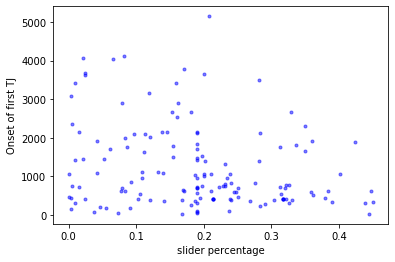

In [12]:
# Make scatter plot
_ = plt.plot(df['SLp'], df['debuttofirstTJ'], marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('slider percentage')
_ = plt.ylabel('Onset of first TJ')

From the scatter plot it is safe to say that it will not be easy to come up with a good linear predictive model, no matter it's only slider percentage or any combination of other variables. However I still give it a shot and try to build a regression tree model from the four best predictors.

##Step 4: Build a regression tree model

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score

mean_SLp=df['SLp'].mean()
df['SLp']=df['SLp'].fillna(mean_SLp)

mean_SLv=df['SLv'].mean()
df['SLv']=df['SLv'].fillna(mean_SLv)

mean_CHp=df['CHv'].mean()
df['CHv']=df['CHv'].fillna(mean_CHp)

# split data into X and y
X = df.loc[:,['FBv','SLp','SLv','CHv']]
Y = df.loc[:,'debuttofirstTJ']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# define the model
model = DecisionTreeRegressor(criterion = 'mse', max_depth=5)
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R Squared Score is:', r2_score(y_test, y_pred))

Mean Absolute Error: 1011.8514235190098
Root Mean Squared Error: 1346.1090531411403
R Squared Score is: -0.3008203763249162


Mean Absolute Error: the mean of the absolute values of the individual prediction errors on over all instances in the test set. It tells us how big of an error we can expect on average<br>

Root Mean Squared Error: By calculating the square root of the mean of the square of all of the error, we arrive at a measure of the size of the error that gives more weight to the large but infrequent errors than the mean. We can also compare RMSE and MAE to determine whether the forecast contains large but infrequent errors: the larger the difference between RMSE and MAE the more inconsistent the error size<br>

R-square is defined as the proportion of variance explained by the model, if the model is actually worse than just fitting a horizontal line then R-square is negative. Although it's definitely not good to see that in our model, we can still take a look at the feature importance, indicating the relative importance of each feature when making a prediction.

Take a look at the feature importance

In [18]:
for importance, name in sorted(zip(model.feature_importances_, X_train.columns),reverse=True):
 print(name, importance)

SLv 0.3725306848179174
SLp 0.31259548831222556
CHv 0.18620779200459422
FBv 0.1286660348652628


#Conclusion

Although it is really hard to come up with a good model for these variables, we can still get the idea of which variables(Fastball velocity, Slider percentage, Slider velocity, Changeup velocity) are more significantly related with the onset of first time Tommy John Surgery. Also a negative finding is a finding as well, from this research we get to know that the pitch type, usage, velocity and movement seem not to have a great correlation with the onset of first time TJ surgery.